# Azure Evaluation On Stuttering

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stuttering count
4. Get Error & Stuttering Type ==> show which Stuttering type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

*** 

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stuttering Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [4]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [5]:
!pip install pandas numpy scipy tqdm

---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [6]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """
    
    candidate_tokens = list(candidate)
    reference_tokens = list(reference)
    
    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)
    
    dist_mat = np.zeros((ref_len, cand_len), dtype=int)
    
    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j
        
    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1
                
            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)
            
    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion

In [7]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [8]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_azure = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Azure.csv", delimiter=",")

del net_aigenerated_data_azure[net_aigenerated_data_azure.columns[0]]

In [9]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

/scratch/1392462.1.cds/ipykernel_2502639/4285821246.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])


In [10]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [11]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [12]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...
1,D0001_A,790.130000,796.580000,电视剧。
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？
3,D0001_A,2016.780000,2035.673559,很很精准，对。
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_azure`**

***

## WER Analysis

In [13]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_azure.iterrows(), total=len(net_aigenerated_data_azure)):
    
    mask_large = (
        (net_aigenerated_data_azure["Filename"] == row["Filename"]) &
        (net_aigenerated_data_azure["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_azure.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    azure = large_row["Azure"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(azure) or not isinstance(azure, str):
        print("Skipping due to missing or non-string Azure.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(azure, cleaned_transcript)
        
        net_aigenerated_data_azure.loc[mask_large, "WER"] = wer_value
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"] = stutterance_count

        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_azure = net_aigenerated_data_azure.assign(NA_Count=na_count_large)
net_aigenerated_data_azure = net_aigenerated_data_azure.assign(NA_Cleaned_Count=na_count_cleaned)

  0%|          | 42/37253 [00:00<05:38, 109.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 82/37253 [00:00<05:00, 123.83it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 110/37253 [00:00<04:44, 130.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 137/37253 [00:01<05:07, 120.88it/s]

Skipping due to missing or non-string Azure.


  0%|          | 176/37253 [00:01<05:03, 122.31it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 800/37253 [00:07<04:45, 127.82it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 874/37253 [00:07<05:18, 114.14it/s]

Skipping due to missing or non-string Azure.


  4%|▎         | 1347/37253 [00:11<05:34, 107.33it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1508/37253 [00:13<05:18, 112.36it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1659/37253 [00:14<05:23, 110.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1682/37253 [00:14<05:31, 107.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1846/37253 [00:16<05:17, 111.48it/s]

Skipping: One of the rows is empty.


  5%|▌         | 1987/37253 [00:17<05:22, 109.40it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▌         | 2009/37253 [00:17<05:32, 106.08it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2078/37253 [00:18<05:28, 107.18it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2158/37253 [00:19<05:14, 111.64it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2206/37253 [00:19<05:10, 112.89it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2254/37253 [00:20<05:16, 110.72it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2482/37253 [00:22<05:26, 106.36it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2566/37253 [00:23<04:53, 118.12it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2658/37253 [00:23<04:43, 122.21it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  7%|▋         | 2684/37253 [00:24<04:44, 121.56it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2723/37253 [00:24<04:42, 122.18it/s]

Skipping due to missing or non-string Azure.


  8%|▊         | 2829/37253 [00:25<05:35, 102.68it/s]

Skipping due to missing or non-string Azure.


  9%|▊         | 3220/37253 [00:29<05:37, 100.76it/s]

Skipping due to missing or non-string Azure.


  9%|▉         | 3487/37253 [00:32<06:16, 89.70it/s] 

Skipping due to missing or non-string Azure.


 10%|▉         | 3724/37253 [00:34<04:36, 121.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3751/37253 [00:34<04:23, 126.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3803/37253 [00:34<04:30, 123.48it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3842/37253 [00:35<04:30, 123.31it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 3997/37253 [00:36<05:07, 108.15it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4042/37253 [00:37<05:07, 108.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4076/37253 [00:37<05:12, 106.32it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4121/37253 [00:37<05:07, 107.65it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4179/37253 [00:38<05:01, 109.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4212/37253 [00:38<05:19, 103.55it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4268/37253 [00:39<05:21, 102.63it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4312/37253 [00:39<05:21, 102.34it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4336/37253 [00:39<05:16, 104.07it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4391/37253 [00:40<05:07, 106.80it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4430/37253 [00:40<04:35, 119.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4596/37253 [00:41<04:33, 119.53it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4634/37253 [00:42<04:36, 117.96it/s]

Skipping due to missing or non-string Azure.


 13%|█▎        | 4686/37253 [00:42<04:20, 125.19it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 13%|█▎        | 4932/37253 [00:44<04:56, 108.85it/s]

Skipping due to missing or non-string Azure.


 14%|█▎        | 5049/37253 [00:45<04:08, 129.71it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▎        | 5105/37253 [00:46<04:00, 133.64it/s]

Skipping due to missing or non-string Azure.


 14%|█▍        | 5175/37253 [00:46<04:02, 132.30it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▍        | 5330/37253 [00:48<04:29, 118.35it/s]

Skipping due to missing or non-string Azure.


 15%|█▍        | 5446/37253 [00:49<04:20, 122.18it/s]

Skipping due to missing or non-string Azure.


 15%|█▌        | 5747/37253 [00:51<05:40, 92.46it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▌        | 5836/37253 [00:52<04:54, 106.81it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5870/37253 [00:53<04:51, 107.80it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5909/37253 [00:53<04:18, 121.12it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5964/37253 [00:53<04:05, 127.46it/s]

Skipping due to missing or non-string Azure.


 16%|█▋        | 6065/37253 [00:54<04:24, 117.98it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▋        | 6101/37253 [00:55<04:28, 116.01it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6150/37253 [00:55<04:36, 112.43it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6175/37253 [00:55<04:25, 116.92it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6213/37253 [00:55<04:21, 118.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6252/37253 [00:56<04:11, 123.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6279/37253 [00:56<04:01, 128.26it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6320/37253 [00:56<04:11, 123.07it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6394/37253 [00:57<04:40, 110.16it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6524/37253 [00:58<04:37, 110.59it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6574/37253 [00:59<04:16, 119.67it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 18%|█▊        | 6745/37253 [01:00<04:25, 114.98it/s]

Skipping due to missing or non-string Azure.


 19%|█▊        | 6919/37253 [01:01<04:10, 121.26it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 6986/37253 [01:02<03:56, 127.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 19%|█▉        | 7159/37253 [01:03<03:51, 130.00it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 7238/37253 [01:04<04:17, 116.62it/s]

Skipping due to missing or non-string Azure.


 20%|█▉        | 7383/37253 [01:05<04:22, 113.82it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7468/37253 [01:06<04:14, 117.05it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7541/37253 [01:07<04:11, 118.04it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7566/37253 [01:07<04:10, 118.55it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7726/37253 [01:08<04:05, 120.39it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7867/37253 [01:09<04:23, 111.42it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7894/37253 [01:10<04:00, 121.83it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 21%|██▏       | 7959/37253 [01:10<03:57, 123.34it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8078/37253 [01:11<03:49, 127.00it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8120/37253 [01:12<03:40, 132.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8188/37253 [01:12<03:53, 124.58it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8242/37253 [01:12<03:55, 123.36it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8294/37253 [01:13<04:00, 120.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8320/37253 [01:13<04:02, 119.33it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8357/37253 [01:13<04:06, 117.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8395/37253 [01:14<04:10, 115.02it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8530/37253 [01:15<03:41, 129.90it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8632/37253 [01:16<04:01, 118.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 24%|██▎       | 8779/37253 [01:17<04:18, 110.16it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 8850/37253 [01:18<04:20, 109.03it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 8963/37253 [01:19<04:11, 112.38it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 9036/37253 [01:19<04:05, 114.76it/s]

Skipping due to missing or non-string Azure.


 25%|██▍       | 9215/37253 [01:21<03:48, 122.85it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 25%|██▌       | 9373/37253 [01:22<04:23, 105.86it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 26%|██▌       | 9509/37253 [01:23<03:50, 120.12it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9614/37253 [01:24<03:52, 118.77it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9687/37253 [01:25<03:54, 117.49it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9762/37253 [01:26<03:50, 119.11it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9798/37253 [01:26<03:57, 115.38it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9848/37253 [01:26<03:56, 115.80it/s]

Skipping due to missing or non-string Azure.


 27%|██▋       | 9945/37253 [01:27<03:51, 117.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10081/37253 [01:28<03:29, 129.87it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10108/37253 [01:28<03:27, 130.87it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10309/37253 [01:30<03:32, 127.07it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10351/37253 [01:30<03:25, 130.78it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10421/37253 [01:31<03:35, 124.54it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10461/37253 [01:31<03:39, 121.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10486/37253 [01:31<03:46, 118.12it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▊       | 10623/37253 [01:33<03:41, 120.42it/s]

Skipping due to missing or non-string Azure.


 29%|██▊       | 10675/37253 [01:33<03:36, 122.61it/s]

Skipping due to missing or non-string Azure.


 29%|██▊       | 10703/37253 [01:33<03:28, 127.25it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10817/37253 [01:34<03:34, 123.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10873/37253 [01:35<03:18, 132.68it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10901/37253 [01:35<03:20, 131.46it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10928/37253 [01:35<03:33, 123.02it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11193/37253 [01:37<03:41, 117.67it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11265/37253 [01:38<03:44, 115.64it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11291/37253 [01:38<03:36, 120.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11343/37253 [01:39<03:31, 122.44it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11497/37253 [01:40<03:27, 124.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11550/37253 [01:40<03:21, 127.87it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11589/37253 [01:41<03:37, 117.82it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11613/37253 [01:41<03:42, 115.05it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11637/37253 [01:41<03:48, 111.89it/s]

Skipping due to missing or non-string Azure.


 31%|███▏      | 11730/37253 [01:42<03:55, 108.60it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 11973/37253 [01:44<03:30, 119.88it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 12066/37253 [01:45<03:20, 125.58it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12180/37253 [01:46<03:29, 119.45it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12219/37253 [01:46<03:25, 121.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12246/37253 [01:46<03:20, 124.62it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12309/37253 [01:47<03:34, 116.54it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12385/37253 [01:47<03:26, 120.71it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12425/37253 [01:48<03:22, 122.62it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12466/37253 [01:48<03:13, 128.02it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12636/37253 [01:49<03:17, 124.60it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12688/37253 [01:50<03:15, 125.66it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12776/37253 [01:51<03:33, 114.80it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12813/37253 [01:51<03:34, 113.78it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12861/37253 [01:51<03:41, 109.92it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12899/37253 [01:52<03:24, 119.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12938/37253 [01:52<03:29, 115.87it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12974/37253 [01:52<03:38, 110.96it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13049/37253 [01:53<03:30, 115.23it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▌      | 13110/37253 [01:54<03:31, 114.18it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13159/37253 [01:54<03:30, 114.60it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13232/37253 [01:55<03:32, 113.29it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13259/37253 [01:55<03:18, 120.65it/s]

Skipping due to missing or non-string Azure.


 36%|███▌      | 13455/37253 [01:56<03:13, 122.93it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13510/37253 [01:57<03:01, 130.54it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13538/37253 [01:57<02:59, 132.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 37%|███▋      | 13737/37253 [01:59<03:26, 113.61it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13763/37253 [01:59<03:16, 119.30it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13790/37253 [01:59<03:10, 122.95it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13869/37253 [02:00<03:10, 122.45it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 13977/37253 [02:01<03:33, 109.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14056/37253 [02:02<03:02, 127.10it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14126/37253 [02:02<02:59, 129.02it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14208/37253 [02:03<02:58, 128.97it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14276/37253 [02:03<03:08, 121.74it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14302/37253 [02:03<03:08, 122.05it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14329/37253 [02:04<03:05, 123.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14379/37253 [02:04<03:17, 115.88it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14417/37253 [02:04<03:10, 119.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14443/37253 [02:05<03:06, 122.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14469/37253 [02:05<03:04, 123.28it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14507/37253 [02:05<03:18, 114.60it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14687/37253 [02:07<03:04, 122.15it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14741/37253 [02:07<02:53, 129.60it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14838/37253 [02:08<03:12, 116.68it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 40%|███▉      | 14886/37253 [02:08<03:23, 109.89it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 14958/37253 [02:09<03:12, 115.85it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 15020/37253 [02:09<03:05, 119.88it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15135/37253 [02:10<02:58, 123.77it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15224/37253 [02:11<02:37, 139.53it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15299/37253 [02:12<02:33, 142.65it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15329/37253 [02:12<02:33, 142.94it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████▏     | 15389/37253 [02:12<02:33, 142.86it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15479/37253 [02:13<02:33, 141.41it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15539/37253 [02:13<02:33, 141.40it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15659/37253 [02:14<02:33, 140.82it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15704/37253 [02:15<02:32, 141.54it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 15989/37253 [02:17<02:30, 141.64it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16034/37253 [02:17<02:29, 141.55it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16094/37253 [02:17<02:29, 141.75it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16184/37253 [02:18<02:27, 142.44it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16319/37253 [02:19<02:27, 141.93it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16394/37253 [02:19<02:27, 141.61it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16439/37253 [02:20<02:26, 141.67it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16469/37253 [02:20<02:26, 141.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▍     | 16739/37253 [02:22<02:24, 141.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▌     | 16784/37253 [02:22<02:24, 141.19it/s]

Skipping due to missing or non-string Azure.


 45%|████▌     | 16844/37253 [02:23<02:24, 141.58it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 16964/37253 [02:23<02:23, 141.28it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17159/37253 [02:25<02:21, 141.68it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17189/37253 [02:25<02:20, 142.39it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17489/37253 [02:27<02:18, 142.33it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17534/37253 [02:27<02:18, 142.40it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17579/37253 [02:28<02:18, 142.15it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17609/37253 [02:28<02:18, 141.71it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17714/37253 [02:29<02:18, 141.57it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17819/37253 [02:29<02:17, 141.48it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17864/37253 [02:30<02:16, 141.92it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17909/37253 [02:30<02:15, 142.46it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▊     | 18074/37253 [02:31<02:14, 142.84it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▉     | 18194/37253 [02:32<02:14, 141.59it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18299/37253 [02:33<02:13, 141.84it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18374/37253 [02:33<02:14, 140.53it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18479/37253 [02:34<02:12, 141.39it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18524/37253 [02:34<02:12, 141.36it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18569/37253 [02:35<02:11, 141.61it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18644/37253 [02:35<02:11, 141.48it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18749/37253 [02:36<02:10, 142.07it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 50%|█████     | 18779/37253 [02:36<02:09, 142.18it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18884/37253 [02:37<02:09, 141.97it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18959/37253 [02:37<02:09, 141.79it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 19034/37253 [02:38<02:07, 142.73it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19094/37253 [02:38<02:08, 141.85it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19139/37253 [02:39<02:10, 138.88it/s]

Skipping due to missing or non-string Azure.


 51%|█████▏    | 19169/37253 [02:39<02:09, 140.18it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19256/37253 [02:40<02:14, 133.99it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19325/37253 [02:40<02:17, 130.47it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19605/37253 [02:42<02:09, 136.04it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19675/37253 [02:43<02:10, 134.39it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19703/37253 [02:43<02:09, 135.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19745/37253 [02:43<02:08, 136.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19885/37253 [02:44<02:08, 134.91it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19969/37253 [02:45<02:07, 135.75it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19997/37253 [02:45<02:06, 136.04it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20039/37253 [02:45<02:06, 135.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20095/37253 [02:46<02:06, 135.83it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20235/37253 [02:47<02:04, 136.61it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20291/37253 [02:47<02:05, 135.54it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20333/37253 [02:48<02:04, 135.80it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20361/37253 [02:48<02:03, 136.88it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20501/37253 [02:49<02:04, 135.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▌    | 20641/37253 [02:50<02:02, 135.21it/s]

Skipping due to missing or non-string Azure.


 56%|█████▋    | 21005/37253 [02:53<01:59, 135.77it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21061/37253 [02:53<01:59, 135.55it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21103/37253 [02:53<01:59, 134.85it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21131/37253 [02:54<01:59, 135.33it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21229/37253 [02:54<01:58, 134.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21313/37253 [02:55<01:57, 135.80it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21461/37253 [02:56<01:51, 141.00it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21551/37253 [02:57<01:51, 141.20it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 58%|█████▊    | 21731/37253 [02:58<01:50, 140.96it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21776/37253 [02:58<01:49, 141.14it/s]

Skipping due to missing or non-string Azure.


 59%|█████▊    | 21866/37253 [02:59<01:48, 141.97it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21911/37253 [02:59<01:49, 140.42it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21986/37253 [03:00<01:47, 141.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22016/37253 [03:00<01:47, 141.89it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22046/37253 [03:00<01:47, 141.67it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22091/37253 [03:00<01:46, 142.38it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22136/37253 [03:01<01:45, 142.67it/s]

Skipping due to missing or non-string Azure.


 60%|█████▉    | 22286/37253 [03:02<01:44, 143.15it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22406/37253 [03:03<01:44, 141.72it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22526/37253 [03:03<01:44, 141.60it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22736/37253 [03:05<01:42, 141.33it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22766/37253 [03:05<01:42, 141.05it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22811/37253 [03:05<01:42, 140.78it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 22931/37253 [03:06<01:41, 141.06it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23021/37253 [03:07<01:40, 141.72it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23111/37253 [03:08<01:40, 141.29it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23156/37253 [03:08<01:39, 141.20it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23306/37253 [03:09<01:38, 141.80it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23336/37253 [03:09<01:38, 141.28it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23381/37253 [03:09<01:38, 141.37it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 63%|██████▎   | 23441/37253 [03:10<01:37, 141.65it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23486/37253 [03:10<01:37, 141.43it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23546/37253 [03:11<01:36, 141.70it/s]

Skipping due to missing or non-string Azure.


 64%|██████▎   | 23741/37253 [03:12<01:35, 142.20it/s]

Skipping due to missing or non-string Azure.


 64%|██████▍   | 23981/37253 [03:14<01:33, 141.74it/s]

Skipping due to missing or non-string Azure.


 65%|██████▍   | 24131/37253 [03:15<01:32, 142.16it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24221/37253 [03:15<01:32, 141.29it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24296/37253 [03:16<01:31, 141.95it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24371/37253 [03:16<01:30, 142.49it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24716/37253 [03:19<01:28, 141.31it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24761/37253 [03:19<01:28, 140.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 67%|██████▋   | 24836/37253 [03:20<01:28, 140.93it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 24986/37253 [03:21<01:26, 141.12it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 25106/37253 [03:22<01:25, 141.26it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 68%|██████▊   | 25286/37253 [03:23<01:25, 140.64it/s]

Skipping due to missing or non-string Azure.


 68%|██████▊   | 25376/37253 [03:24<01:24, 141.32it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25541/37253 [03:25<01:22, 141.36it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25571/37253 [03:25<01:22, 141.16it/s]

Skipping due to missing or non-string Azure.


 69%|██████▉   | 25826/37253 [03:27<01:20, 141.13it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26218/37253 [03:30<01:24, 130.26it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26246/37253 [03:30<01:24, 130.26it/s]

Skipping due to missing or non-string Azure.


 71%|███████   | 26448/37253 [03:31<01:16, 140.37it/s]

Skipping due to missing or non-string Azure.


 72%|███████▏  | 26958/37253 [03:35<01:13, 140.99it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27078/37253 [03:36<01:12, 140.56it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27153/37253 [03:36<01:11, 141.18it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27333/37253 [03:38<01:10, 141.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 74%|███████▎  | 27393/37253 [03:38<01:09, 141.07it/s]

Skipping due to missing or non-string Azure.


 74%|███████▍  | 27528/37253 [03:39<01:09, 140.86it/s]

Skipping due to missing or non-string Azure.


 75%|███████▍  | 27858/37253 [03:41<01:06, 140.99it/s]

Skipping due to missing or non-string Azure.


 76%|███████▌  | 28233/37253 [03:44<01:03, 140.95it/s]

Skipping due to missing or non-string Azure.


 78%|███████▊  | 29236/37253 [03:51<00:56, 140.92it/s]

Skipping due to missing or non-string Azure.


 80%|███████▉  | 29640/37253 [03:54<00:53, 141.96it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30075/37253 [03:57<00:50, 141.52it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████  | 30165/37253 [03:58<00:50, 140.82it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30195/37253 [03:58<00:50, 141.03it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30240/37253 [03:58<00:49, 141.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████▏ | 30270/37253 [03:59<00:49, 141.18it/s]

Skipping due to missing or non-string Azure.


 81%|████████▏ | 30315/37253 [03:59<00:49, 141.06it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30390/37253 [03:59<00:48, 140.99it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30420/37253 [04:00<00:48, 140.91it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30495/37253 [04:00<00:47, 141.56it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30585/37253 [04:01<00:47, 141.38it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30645/37253 [04:01<00:46, 141.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30690/37253 [04:02<00:46, 141.24it/s]

Skipping due to missing or non-string Azure.


 88%|████████▊ | 32697/37253 [04:16<00:32, 141.08it/s]

Skipping due to missing or non-string Azure.


 90%|█████████ | 33709/37253 [04:23<00:27, 127.87it/s]

Skipping due to missing or non-string Azure.


 91%|█████████ | 33985/37253 [04:25<00:25, 126.45it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34037/37253 [04:26<00:25, 127.43it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34063/37253 [04:26<00:25, 126.15it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34104/37253 [04:26<00:24, 129.94it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34589/37253 [04:30<00:18, 141.14it/s]

Skipping: One of the rows is empty.


 94%|█████████▎| 34844/37253 [04:32<00:17, 141.47it/s]

Skipping due to missing or non-string Azure.


 94%|█████████▍| 34964/37253 [04:33<00:16, 140.96it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35858/37253 [04:39<00:10, 138.52it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35888/37253 [04:39<00:09, 140.13it/s]

Skipping due to missing or non-string Azure.


100%|██████████| 37253/37253 [04:49<00:00, 128.51it/s]


In [14]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...,0.072165,1.0,470,0
1,D0001_A,790.130000,796.580000,电视剧。,0.600000,1.0,470,0
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？,0.875000,10.0,470,0
3,D0001_A,2016.780000,2035.673559,很很精准，对。,0.868421,7.0,470,0
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。,0.882353,8.0,470,0
...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。,0.090909,0.0,470,0
37249,P0070,2782.496000,2783.706000,杨幂的电影。,0.000000,0.0,470,0
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？,0.200000,0.0,470,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。,0.166667,0.0,470,0


In [15]:
net_aigenerated_data_azure.to_csv('net_aigenerated_data_azure_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Word Error Rate

In [16]:
## Load data from csv if starting here

net_aigenerated_data_azure = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-azure/net_aigenerated_data_azure_performance_stu.csv', delimiter=',')

In [17]:
import matplotlib.pyplot as plt

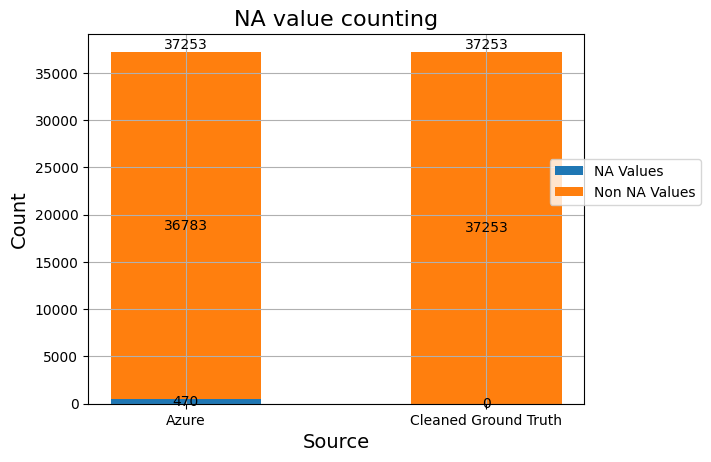

In [18]:
## Null value plots

nonnull_count_large = net_aigenerated_data_azure["NA_Count"].count() - net_aigenerated_data_azure.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_azure.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_azure["NA_Cleaned_Count"].count() - net_aigenerated_data_azure.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_azure.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "Azure",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

totals = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count
    totals += count
    ax.bar_label(p, label_type="center")
    

# Add total counts above the bars
for i, total in enumerate(totals):
    ax.text(i, total + 1, str(int(total)), ha='center', va='bottom', fontsize=10)


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(bbox_to_anchor = (1.25, 0.6), loc='center right')
ax.grid(True)

plt.show()

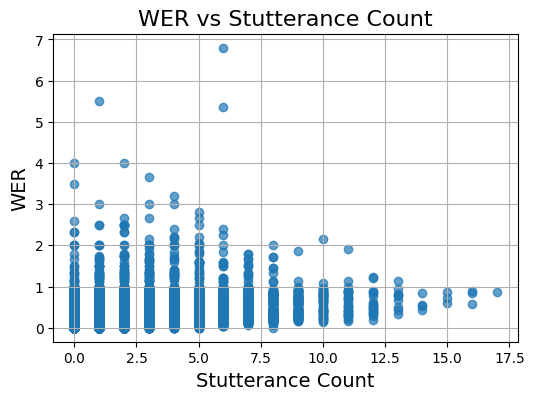

In [19]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_azure['WER_Binned'] = np.round(net_aigenerated_data_azure['WER'], 2)

grouped_data = net_aigenerated_data_azure.groupby(
    ['Stutterance_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stutterance_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [38]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = 0.43824975891281576


In [42]:
net_aigenerated_data_azure[["WER", "rougel-f1", "rouge1-f1", "rouge2-f1"]].describe()

,WER,rougel-f1,rouge1-f1,rouge2-f1
count,36778.000000,36778.000000,36778.000000,36778.000000
mean,0.210741,0.810067,0.833562,0.660723
std,0.261580,0.197649,0.191794,0.312640
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.714286,0.750000,0.461538
50%,0.133333,0.857143,0.892308,0.714286
75%,0.300000,1.000000,1.000000,1.000000
max,6.800000,1.000000,1.000000,1.000000


***

## ROUGE-N/L Scores (Semantic Evaluation)

In [20]:
from rouge_chinese import Rouge
import jieba

In [21]:
rouge = Rouge()

In [22]:
print_ = True

for index, row in tqdm(net_aigenerated_data_azure.iterrows(), total=len(net_aigenerated_data_azure)):
    
    mask_large = (
        (net_aigenerated_data_azure["Filename"] == row["Filename"]) &
        (net_aigenerated_data_azure["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_azure.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    azure = large_row["Azure"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(azure) or not isinstance(azure, str):
        print("Skipping due to missing or non-string Azure.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(azure)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_azure.loc[mask_large, "rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_azure.loc[mask_large, "rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_azure.loc[mask_large, "rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_azure.loc[mask_large, "rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_azure.loc[mask_large, "rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"] = stutterance_count

        if (print_):
            print(net_aigenerated_data_azure)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_azure.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/1392462.1.cds/jieba.cache
Loading model cost 0.639 seconds.
Prefix dict has been built successfully.
  0%|          | 11/37253 [00:00<33:25, 18.57it/s] 

      Filename   Start_time     End_time  \
0      D0001_A  2081.540000  2109.650000   
1      D0001_A   790.130000   796.580000   
2      D0001_A  1562.083518  1586.220000   
3      D0001_A  2016.780000  2035.673559   
4      D0001_A  1682.670000  1709.110000   
...        ...          ...          ...   
37248    P0070  2586.616000  2589.346000   
37249    P0070  2782.496000  2783.706000   
37250    P0070  2995.296000  2998.116000   
37251    P0070  2604.066000  2606.656000   
37252    P0070  2434.606000  2436.576000   

                                                   Azure       WER  \
0      我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...  0.072165   
1                                                   电视剧。  0.600000   
2                                               这部剧是不怎么？  0.875000   
3                                                很很精准，对。  0.868421   
4                                            一个，那个是，嗯，叫。  0.882353   
...                                                

  0%|          | 43/37253 [00:01<09:41, 64.01it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 75/37253 [00:01<07:09, 86.51it/s]

Skipping due to missing or non-string Azure.


  0%|          | 97/37253 [00:01<06:31, 94.96it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 120/37253 [00:01<06:08, 100.69it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  0%|          | 175/37253 [00:02<06:11, 99.83it/s] 

Skipping due to missing or non-string Azure.


  2%|▏         | 798/37253 [00:08<06:01, 100.88it/s]

Skipping due to missing or non-string Azure.


  2%|▏         | 882/37253 [00:09<06:06, 99.19it/s] 

Skipping due to missing or non-string Azure.


  4%|▎         | 1352/37253 [00:14<06:10, 97.02it/s] 

Skipping due to missing or non-string Azure.


  4%|▍         | 1513/37253 [00:15<06:02, 98.69it/s]

Skipping due to missing or non-string Azure.


  4%|▍         | 1655/37253 [00:17<05:55, 100.20it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1677/37253 [00:17<05:53, 100.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▍         | 1840/37253 [00:19<05:57, 99.09it/s] 

Skipping: One of the rows is empty.


  5%|▌         | 1982/37253 [00:20<05:50, 100.51it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  5%|▌         | 2004/37253 [00:20<05:55, 99.20it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2077/37253 [00:21<05:56, 98.74it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2159/37253 [00:22<05:54, 99.04it/s]

Skipping due to missing or non-string Azure.


  6%|▌         | 2201/37253 [00:22<05:50, 100.00it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  6%|▌         | 2255/37253 [00:23<05:51, 99.70it/s] 

Skipping due to missing or non-string Azure.


  7%|▋         | 2486/37253 [00:25<05:52, 98.60it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2557/37253 [00:26<05:50, 98.98it/s]

Skipping due to missing or non-string Azure.


  7%|▋         | 2651/37253 [00:27<05:44, 100.49it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


  7%|▋         | 2684/37253 [00:27<05:45, 99.99it/s] 

Skipping due to missing or non-string Azure.


  7%|▋         | 2717/37253 [00:28<05:43, 100.59it/s]

Skipping due to missing or non-string Azure.


  8%|▊         | 2829/37253 [00:29<05:55, 96.89it/s] 

Skipping due to missing or non-string Azure.


  9%|▊         | 3220/37253 [00:33<05:55, 95.72it/s]

Skipping due to missing or non-string Azure.


  9%|▉         | 3490/37253 [00:36<06:01, 93.31it/s]

Skipping due to missing or non-string Azure.


 10%|▉         | 3723/37253 [00:38<05:35, 99.91it/s]

Skipping due to missing or non-string Azure.


 10%|█         | 3745/37253 [00:38<05:26, 102.48it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3767/37253 [00:39<05:25, 102.74it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3800/37253 [00:39<05:28, 101.96it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 10%|█         | 3844/37253 [00:39<05:31, 100.74it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4000/37253 [00:41<05:31, 100.24it/s]

Skipping due to missing or non-string Azure.


 11%|█         | 4044/37253 [00:41<05:26, 101.82it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4077/37253 [00:42<05:24, 102.13it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4121/37253 [00:42<05:24, 102.01it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█         | 4176/37253 [00:43<05:25, 101.55it/s]

Skipping due to missing or non-string Azure.


 11%|█▏        | 4198/37253 [00:43<05:19, 103.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 11%|█▏        | 4270/37253 [00:44<05:34, 98.59it/s] 

Skipping due to missing or non-string Azure.


 12%|█▏        | 4311/37253 [00:44<05:37, 97.75it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4341/37253 [00:44<05:36, 97.77it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4392/37253 [00:45<05:32, 98.95it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4425/37253 [00:45<05:18, 103.14it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4447/37253 [00:45<05:19, 102.77it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4598/37253 [00:47<05:24, 100.68it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 12%|█▏        | 4609/37253 [00:47<05:23, 100.92it/s]

Skipping due to missing or non-string Azure.


 12%|█▏        | 4630/37253 [00:47<06:07, 88.83it/s] 

Skipping due to missing or non-string Azure.


 13%|█▎        | 4682/37253 [00:48<05:31, 98.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 13%|█▎        | 4929/37253 [00:50<05:26, 99.13it/s] 

Skipping due to missing or non-string Azure.


 14%|█▎        | 5034/37253 [00:51<05:17, 101.37it/s]

Skipping due to missing or non-string Azure.


 14%|█▎        | 5067/37253 [00:52<05:16, 101.67it/s]

Skipping due to missing or non-string Azure.


 14%|█▎        | 5100/37253 [00:52<05:15, 102.04it/s]

Skipping due to missing or non-string Azure.


 14%|█▍        | 5166/37253 [00:53<05:13, 102.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 14%|█▍        | 5330/37253 [00:54<05:22, 98.92it/s] 

Skipping due to missing or non-string Azure.


 15%|█▍        | 5433/37253 [00:55<05:21, 99.07it/s]

Skipping due to missing or non-string Azure.


 15%|█▌        | 5753/37253 [00:59<05:33, 94.59it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▌        | 5834/37253 [01:00<05:21, 97.61it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5865/37253 [01:00<05:21, 97.64it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5907/37253 [01:00<05:13, 100.07it/s]

Skipping due to missing or non-string Azure.


 16%|█▌        | 5961/37253 [01:01<05:10, 100.63it/s]

Skipping due to missing or non-string Azure.


 16%|█▋        | 6064/37253 [01:02<05:12, 99.92it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 16%|█▋        | 6094/37253 [01:02<05:15, 98.79it/s]

Skipping due to missing or non-string Azure.


 16%|█▋        | 6145/37253 [01:03<05:16, 98.34it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6166/37253 [01:03<05:13, 99.11it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6206/37253 [01:03<05:15, 98.49it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6228/37253 [01:04<05:09, 100.28it/s]

Skipping due to missing or non-string Azure.


 17%|█▋        | 6250/37253 [01:04<05:05, 101.47it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6272/37253 [01:04<05:00, 103.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6305/37253 [01:04<05:02, 102.35it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 17%|█▋        | 6388/37253 [01:05<05:17, 97.07it/s] 

Skipping due to missing or non-string Azure.


 18%|█▊        | 6529/37253 [01:07<05:13, 98.10it/s]

Skipping due to missing or non-string Azure.


 18%|█▊        | 6571/37253 [01:07<05:01, 101.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 18%|█▊        | 6744/37253 [01:09<05:07, 99.13it/s] 

Skipping due to missing or non-string Azure.


 19%|█▊        | 6916/37253 [01:10<05:07, 98.76it/s]

Skipping due to missing or non-string Azure.


 19%|█▊        | 6979/37253 [01:11<05:00, 100.90it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 19%|█▉        | 7150/37253 [01:13<04:58, 100.80it/s]

Skipping due to missing or non-string Azure.


 19%|█▉        | 7234/37253 [01:14<05:04, 98.72it/s] 

Skipping due to missing or non-string Azure.


 20%|█▉        | 7385/37253 [01:15<05:07, 97.12it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7466/37253 [01:16<05:00, 99.22it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7537/37253 [01:17<04:59, 99.06it/s]

Skipping due to missing or non-string Azure.


 20%|██        | 7558/37253 [01:17<04:56, 100.06it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7720/37253 [01:19<04:56, 99.68it/s] 

Skipping due to missing or non-string Azure.


 21%|██        | 7861/37253 [01:20<05:01, 97.60it/s]

Skipping due to missing or non-string Azure.


 21%|██        | 7893/37253 [01:20<04:49, 101.26it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 21%|██▏       | 7958/37253 [01:21<04:53, 99.83it/s] 

Skipping due to missing or non-string Azure.


 22%|██▏       | 8071/37253 [01:22<04:51, 100.04it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8115/37253 [01:23<04:45, 102.06it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8192/37253 [01:23<04:45, 101.79it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8236/37253 [01:24<04:47, 100.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8290/37253 [01:24<04:49, 100.06it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8323/37253 [01:25<04:48, 100.15it/s]

Skipping due to missing or non-string Azure.


 22%|██▏       | 8356/37253 [01:25<04:43, 101.75it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 22%|██▏       | 8378/37253 [01:25<04:45, 101.09it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8411/37253 [01:26<04:48, 100.07it/s]

Skipping due to missing or non-string Azure.


 23%|██▎       | 8521/37253 [01:27<04:43, 101.17it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 23%|██▎       | 8627/37253 [01:28<04:44, 100.48it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 24%|██▎       | 8780/37253 [01:29<04:50, 97.96it/s] 

Skipping due to missing or non-string Azure.


 24%|██▎       | 8841/37253 [01:30<04:50, 97.86it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 8962/37253 [01:31<04:48, 98.23it/s]

Skipping due to missing or non-string Azure.


 24%|██▍       | 9033/37253 [01:32<04:48, 97.90it/s]

Skipping due to missing or non-string Azure.


 25%|██▍       | 9207/37253 [01:34<04:36, 101.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 25%|██▌       | 9370/37253 [01:35<04:45, 97.71it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 26%|██▌       | 9513/37253 [01:37<04:39, 99.40it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9616/37253 [01:38<04:39, 99.02it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9687/37253 [01:38<04:38, 98.89it/s]

Skipping due to missing or non-string Azure.


 26%|██▌       | 9758/37253 [01:39<04:38, 98.87it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9799/37253 [01:40<04:39, 98.31it/s]

Skipping due to missing or non-string Azure.


 26%|██▋       | 9840/37253 [01:40<04:38, 98.37it/s]

Skipping due to missing or non-string Azure.


 27%|██▋       | 9943/37253 [01:41<04:32, 100.25it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10073/37253 [01:42<04:27, 101.58it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 27%|██▋       | 10106/37253 [01:43<04:27, 101.43it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10304/37253 [01:45<04:28, 100.32it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10348/37253 [01:45<04:26, 100.98it/s]

Skipping due to missing or non-string Azure.


 28%|██▊       | 10413/37253 [01:46<04:25, 101.13it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10456/37253 [01:46<04:24, 101.25it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10489/37253 [01:47<04:25, 100.94it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 28%|██▊       | 10611/37253 [01:48<04:27, 99.51it/s] 

Skipping due to missing or non-string Azure.


 29%|██▊       | 10673/37253 [01:48<04:26, 99.78it/s] 

Skipping due to missing or non-string Azure.


 29%|██▊       | 10695/37253 [01:49<04:19, 102.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10811/37253 [01:50<04:19, 101.78it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10866/37253 [01:50<04:17, 102.67it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10888/37253 [01:51<04:15, 103.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 29%|██▉       | 10932/37253 [01:51<04:21, 100.57it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11185/37253 [01:54<04:22, 99.43it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11267/37253 [01:54<04:20, 99.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11289/37253 [01:55<04:16, 101.13it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 30%|███       | 11344/37253 [01:55<04:17, 100.55it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11498/37253 [01:57<04:14, 101.31it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 31%|███       | 11553/37253 [01:57<04:16, 100.29it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11584/37253 [01:58<04:18, 99.31it/s] 

Skipping due to missing or non-string Azure.


 31%|███       | 11615/37253 [01:58<04:19, 98.81it/s]

Skipping due to missing or non-string Azure.


 31%|███       | 11635/37253 [01:58<04:20, 98.19it/s]

Skipping due to missing or non-string Azure.


 31%|███▏      | 11726/37253 [01:59<04:23, 96.95it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 11968/37253 [02:02<04:14, 99.31it/s]

Skipping due to missing or non-string Azure.


 32%|███▏      | 12061/37253 [02:02<04:09, 100.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12185/37253 [02:04<04:13, 99.04it/s] 

Skipping due to missing or non-string Azure.


 33%|███▎      | 12206/37253 [02:04<04:06, 101.46it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12239/37253 [02:04<04:08, 100.63it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12261/37253 [02:04<04:08, 100.47it/s]

Skipping due to missing or non-string Azure.


 33%|███▎      | 12302/37253 [02:05<04:11, 99.10it/s] 

Skipping due to missing or non-string Azure.


 33%|███▎      | 12385/37253 [02:06<04:10, 99.47it/s] 

Skipping due to missing or non-string Azure.


 33%|███▎      | 12417/37253 [02:06<04:07, 100.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 33%|███▎      | 12461/37253 [02:06<04:05, 101.00it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12638/37253 [02:08<04:07, 99.57it/s] 

Skipping due to missing or non-string Azure.


 34%|███▍      | 12680/37253 [02:09<04:05, 100.08it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12771/37253 [02:10<04:08, 98.35it/s] 

Skipping due to missing or non-string Azure.


 34%|███▍      | 12821/37253 [02:10<04:08, 98.45it/s]

Skipping due to missing or non-string Azure.


 34%|███▍      | 12851/37253 [02:10<04:10, 97.33it/s]

Skipping due to missing or non-string Azure.


 35%|███▍      | 12905/37253 [02:11<03:57, 102.50it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12938/37253 [02:11<04:03, 99.98it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▍      | 12971/37253 [02:12<04:05, 98.89it/s] 

Skipping due to missing or non-string Azure.


 35%|███▌      | 13042/37253 [02:12<04:08, 97.53it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 35%|███▌      | 13103/37253 [02:13<04:07, 97.67it/s]

Skipping due to missing or non-string Azure.


 35%|███▌      | 13155/37253 [02:13<04:02, 99.36it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13226/37253 [02:14<04:01, 99.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 36%|███▌      | 13259/37253 [02:15<03:58, 100.81it/s]

Skipping due to missing or non-string Azure.


 36%|███▌      | 13445/37253 [02:16<03:58, 99.76it/s] 

Skipping due to missing or non-string Azure.


 36%|███▋      | 13509/37253 [02:17<03:54, 101.21it/s]

Skipping due to missing or non-string Azure.


 36%|███▋      | 13531/37253 [02:17<03:50, 103.12it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 37%|███▋      | 13727/37253 [02:19<03:57, 99.19it/s] 

Skipping due to missing or non-string Azure.


 37%|███▋      | 13758/37253 [02:20<03:56, 99.43it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13791/37253 [02:20<03:54, 100.20it/s]

Skipping due to missing or non-string Azure.


 37%|███▋      | 13856/37253 [02:21<03:53, 100.36it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 13978/37253 [02:22<03:56, 98.21it/s] 

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14051/37253 [02:23<03:50, 100.78it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14117/37253 [02:23<03:48, 101.26it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14202/37253 [02:24<03:48, 101.04it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14268/37253 [02:25<03:49, 100.15it/s]

Skipping due to missing or non-string Azure.


 38%|███▊      | 14301/37253 [02:25<03:47, 100.81it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 38%|███▊      | 14323/37253 [02:25<03:43, 102.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14378/37253 [02:26<03:46, 100.88it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14411/37253 [02:26<03:45, 101.28it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▊      | 14433/37253 [02:26<03:46, 100.94it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14455/37253 [02:27<03:45, 101.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 39%|███▉      | 14499/37253 [02:27<03:48, 99.42it/s] 

Skipping due to missing or non-string Azure.


 39%|███▉      | 14683/37253 [02:29<03:47, 99.40it/s]

Skipping due to missing or non-string Azure.


 39%|███▉      | 14694/37253 [02:29<03:44, 100.41it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14738/37253 [02:29<03:42, 101.19it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14837/37253 [02:30<03:47, 98.56it/s] 

Skipping due to missing or non-string Azure.


 40%|███▉      | 14857/37253 [02:31<03:48, 98.17it/s]

Skipping due to missing or non-string Azure.


 40%|███▉      | 14877/37253 [02:31<03:47, 98.18it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 14948/37253 [02:32<03:46, 98.68it/s]

Skipping due to missing or non-string Azure.


 40%|████      | 15019/37253 [02:32<03:44, 99.01it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15121/37253 [02:33<03:44, 98.70it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15154/37253 [02:34<03:37, 101.49it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15209/37253 [02:34<03:35, 102.45it/s]

Skipping due to missing or non-string Azure.


 41%|████      | 15286/37253 [02:35<03:32, 103.58it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15319/37253 [02:35<03:28, 105.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 41%|████      | 15352/37253 [02:36<03:35, 101.55it/s]

Skipping due to missing or non-string Azure.


 41%|████▏     | 15374/37253 [02:36<03:34, 102.21it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15473/37253 [02:37<03:34, 101.71it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15528/37253 [02:37<03:33, 101.71it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15649/37253 [02:38<03:32, 101.60it/s]

Skipping due to missing or non-string Azure.


 42%|████▏     | 15704/37253 [02:39<03:30, 102.19it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 15979/37253 [02:42<03:27, 102.60it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16034/37253 [02:42<03:26, 102.60it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16078/37253 [02:43<03:26, 102.79it/s]

Skipping due to missing or non-string Azure.


 43%|████▎     | 16177/37253 [02:44<03:25, 102.73it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16309/37253 [02:45<03:24, 102.63it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16397/37253 [02:46<03:23, 102.51it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16430/37253 [02:46<03:22, 102.67it/s]

Skipping due to missing or non-string Azure.


 44%|████▍     | 16463/37253 [02:46<03:22, 102.66it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▍     | 16738/37253 [02:49<03:18, 103.34it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 45%|████▌     | 16782/37253 [02:50<03:19, 102.86it/s]

Skipping due to missing or non-string Azure.


 45%|████▌     | 16837/37253 [02:50<03:19, 102.44it/s]

Skipping due to missing or non-string Azure.


 45%|████▌     | 16947/37253 [02:51<03:18, 102.15it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17145/37253 [02:53<03:16, 102.55it/s]

Skipping due to missing or non-string Azure.


 46%|████▌     | 17189/37253 [02:54<03:15, 102.72it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17475/37253 [02:56<03:15, 100.91it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 47%|████▋     | 17497/37253 [02:57<03:12, 102.47it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17530/37253 [02:57<03:11, 102.78it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17574/37253 [02:57<03:11, 102.56it/s]

Skipping due to missing or non-string Azure.


 47%|████▋     | 17607/37253 [02:58<03:09, 103.43it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17706/37253 [02:59<03:11, 101.91it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17805/37253 [03:00<03:09, 102.74it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17849/37253 [03:00<03:08, 102.88it/s]

Skipping due to missing or non-string Azure.


 48%|████▊     | 17882/37253 [03:00<03:07, 103.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 48%|████▊     | 17926/37253 [03:01<03:07, 103.07it/s]

Skipping due to missing or non-string Azure.


 49%|████▊     | 18069/37253 [03:02<03:06, 102.70it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 49%|████▉     | 18190/37253 [03:03<03:07, 101.76it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18300/37253 [03:04<03:05, 102.43it/s]

Skipping due to missing or non-string Azure.


 49%|████▉     | 18377/37253 [03:05<03:04, 102.37it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18476/37253 [03:06<03:03, 102.40it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18520/37253 [03:07<03:02, 102.55it/s]

Skipping due to missing or non-string Azure.


 50%|████▉     | 18564/37253 [03:07<03:02, 102.56it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18641/37253 [03:08<03:01, 102.31it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18740/37253 [03:09<03:01, 102.14it/s]

Skipping due to missing or non-string Azure.


 50%|█████     | 18773/37253 [03:09<02:58, 103.27it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████     | 18872/37253 [03:10<02:59, 102.25it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 18960/37253 [03:11<02:58, 102.55it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 19026/37253 [03:12<02:56, 103.32it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████     | 19048/37253 [03:12<02:56, 103.13it/s]

Skipping due to missing or non-string Azure.


 51%|█████     | 19092/37253 [03:12<02:56, 102.77it/s]

Skipping due to missing or non-string Azure.


 51%|█████▏    | 19125/37253 [03:12<02:54, 103.60it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 51%|█████▏    | 19169/37253 [03:13<02:55, 102.81it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19246/37253 [03:14<02:59, 100.55it/s]

Skipping due to missing or non-string Azure.


 52%|█████▏    | 19323/37253 [03:14<02:55, 102.36it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19598/37253 [03:17<02:51, 102.68it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19664/37253 [03:18<02:51, 102.28it/s]

Skipping due to missing or non-string Azure.


 53%|█████▎    | 19697/37253 [03:18<02:51, 102.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19741/37253 [03:19<02:49, 103.39it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 53%|█████▎    | 19884/37253 [03:20<02:50, 102.10it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19961/37253 [03:21<02:48, 102.36it/s]

Skipping due to missing or non-string Azure.


 54%|█████▎    | 19994/37253 [03:21<02:46, 103.37it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20027/37253 [03:21<02:44, 104.88it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 54%|█████▍    | 20082/37253 [03:22<02:46, 103.13it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20236/37253 [03:23<02:46, 102.47it/s]

Skipping due to missing or non-string Azure.


 54%|█████▍    | 20291/37253 [03:24<02:45, 102.49it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20324/37253 [03:24<02:45, 102.58it/s]

Skipping due to missing or non-string Azure.


 55%|█████▍    | 20357/37253 [03:25<02:43, 103.45it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 55%|█████▍    | 20489/37253 [03:26<02:43, 102.63it/s]

Skipping due to missing or non-string Azure.


 55%|█████▌    | 20522/37253 [03:26<02:43, 102.60it/s]

Skipping due to missing or non-string Azure.


 55%|█████▌    | 20632/37253 [03:27<02:41, 102.64it/s]

Skipping due to missing or non-string Azure.


 56%|█████▋    | 20995/37253 [03:31<02:39, 102.10it/s]

Skipping due to missing or non-string Azure.


 56%|█████▋    | 21017/37253 [03:31<02:42, 99.77it/s] 

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21050/37253 [03:31<02:41, 100.31it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21105/37253 [03:32<02:38, 102.18it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21127/37253 [03:32<02:37, 102.41it/s]

Skipping due to missing or non-string Azure.


 57%|█████▋    | 21226/37253 [03:33<02:35, 103.23it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 57%|█████▋    | 21303/37253 [03:34<02:34, 102.93it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21457/37253 [03:35<02:34, 102.51it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21545/37253 [03:36<02:32, 103.19it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 58%|█████▊    | 21721/37253 [03:38<02:31, 102.51it/s]

Skipping due to missing or non-string Azure.


 58%|█████▊    | 21776/37253 [03:38<02:31, 102.39it/s]

Skipping due to missing or non-string Azure.


 59%|█████▊    | 21853/37253 [03:39<02:30, 102.58it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21897/37253 [03:40<02:29, 102.72it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 21974/37253 [03:40<02:27, 103.44it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 59%|█████▉    | 22007/37253 [03:41<02:28, 102.98it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22040/37253 [03:41<02:28, 102.77it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22084/37253 [03:41<02:27, 102.86it/s]

Skipping due to missing or non-string Azure.


 59%|█████▉    | 22128/37253 [03:42<02:26, 102.90it/s]

Skipping due to missing or non-string Azure.


 60%|█████▉    | 22271/37253 [03:43<02:25, 102.73it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22403/37253 [03:45<02:25, 102.31it/s]

Skipping due to missing or non-string Azure.


 60%|██████    | 22513/37253 [03:46<02:24, 102.34it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22733/37253 [03:48<02:21, 102.39it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22766/37253 [03:48<02:21, 102.49it/s]

Skipping due to missing or non-string Azure.


 61%|██████    | 22810/37253 [03:49<02:21, 102.30it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 22920/37253 [03:50<02:20, 102.36it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23019/37253 [03:51<02:19, 102.37it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23107/37253 [03:51<02:18, 102.37it/s]

Skipping due to missing or non-string Azure.


 62%|██████▏   | 23140/37253 [03:52<02:17, 102.69it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23294/37253 [03:53<02:16, 102.11it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23327/37253 [03:54<02:15, 102.42it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23371/37253 [03:54<02:15, 102.48it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 63%|██████▎   | 23426/37253 [03:55<02:14, 102.65it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23481/37253 [03:55<02:14, 102.65it/s]

Skipping due to missing or non-string Azure.


 63%|██████▎   | 23536/37253 [03:56<02:13, 102.55it/s]

Skipping due to missing or non-string Azure.


 64%|██████▎   | 23734/37253 [03:58<02:12, 102.39it/s]

Skipping due to missing or non-string Azure.


 64%|██████▍   | 23965/37253 [04:00<02:11, 101.06it/s]

Skipping due to missing or non-string Azure.


 65%|██████▍   | 24119/37253 [04:01<02:07, 102.80it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24218/37253 [04:02<02:07, 102.59it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24284/37253 [04:03<02:06, 102.26it/s]

Skipping due to missing or non-string Azure.


 65%|██████▌   | 24372/37253 [04:04<02:08, 100.58it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24713/37253 [04:07<02:02, 102.30it/s]

Skipping due to missing or non-string Azure.


 66%|██████▋   | 24757/37253 [04:08<02:02, 102.41it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 67%|██████▋   | 24834/37253 [04:08<02:01, 102.17it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 24977/37253 [04:10<02:00, 102.16it/s]

Skipping due to missing or non-string Azure.


 67%|██████▋   | 25098/37253 [04:11<01:57, 103.26it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 68%|██████▊   | 25274/37253 [04:13<01:57, 102.20it/s]

Skipping due to missing or non-string Azure.


 68%|██████▊   | 25373/37253 [04:14<01:56, 102.28it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25527/37253 [04:15<01:54, 102.23it/s]

Skipping due to missing or non-string Azure.


 69%|██████▊   | 25560/37253 [04:16<01:54, 102.34it/s]

Skipping due to missing or non-string Azure.


 69%|██████▉   | 25813/37253 [04:18<01:51, 102.25it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26209/37253 [04:22<01:47, 102.41it/s]

Skipping due to missing or non-string Azure.


 70%|███████   | 26253/37253 [04:22<01:47, 102.34it/s]

Skipping due to missing or non-string Azure.


 71%|███████   | 26451/37253 [04:24<01:45, 102.15it/s]

Skipping due to missing or non-string Azure.


 72%|███████▏  | 26956/37253 [04:29<01:40, 102.05it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27066/37253 [04:30<01:39, 102.26it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27143/37253 [04:31<01:38, 102.48it/s]

Skipping due to missing or non-string Azure.


 73%|███████▎  | 27330/37253 [04:33<01:37, 101.84it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 74%|███████▎  | 27385/37253 [04:33<01:36, 102.30it/s]

Skipping due to missing or non-string Azure.


 74%|███████▍  | 27528/37253 [04:35<01:35, 102.11it/s]

Skipping due to missing or non-string Azure.


 75%|███████▍  | 27847/37253 [04:38<01:32, 102.15it/s]

Skipping due to missing or non-string Azure.


 76%|███████▌  | 28234/37253 [04:42<01:28, 102.15it/s]

Skipping due to missing or non-string Azure.


 78%|███████▊  | 29235/37253 [04:52<01:18, 102.24it/s]

Skipping due to missing or non-string Azure.


 80%|███████▉  | 29631/37253 [04:56<01:14, 102.50it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30071/37253 [05:00<01:10, 102.41it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30093/37253 [05:00<01:09, 102.58it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30159/37253 [05:01<01:09, 102.60it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30192/37253 [05:01<01:08, 102.69it/s]

Skipping due to missing or non-string Azure.


 81%|████████  | 30225/37253 [05:01<01:08, 102.59it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 81%|████████▏ | 30269/37253 [05:02<01:07, 102.85it/s]

Skipping due to missing or non-string Azure.


 81%|████████▏ | 30313/37253 [05:02<01:07, 102.56it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30379/37253 [05:03<01:07, 101.70it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30423/37253 [05:03<01:06, 102.51it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30489/37253 [05:04<01:05, 103.03it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30577/37253 [05:05<01:05, 102.36it/s]

Skipping due to missing or non-string Azure.


 82%|████████▏ | 30643/37253 [05:06<01:03, 103.38it/s]

Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.
Skipping due to missing or non-string Azure.


 82%|████████▏ | 30687/37253 [05:06<01:03, 103.12it/s]

Skipping due to missing or non-string Azure.


 88%|████████▊ | 32689/37253 [05:26<00:44, 102.15it/s]

Skipping due to missing or non-string Azure.


 90%|█████████ | 33701/37253 [05:36<00:34, 102.09it/s]

Skipping due to missing or non-string Azure.


 91%|█████████ | 33987/37253 [05:38<00:32, 101.85it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34031/37253 [05:39<00:31, 101.93it/s]

Skipping due to missing or non-string Azure.


 91%|█████████▏| 34064/37253 [05:39<00:31, 101.96it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34097/37253 [05:40<00:30, 102.15it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34592/37253 [05:44<00:26, 102.28it/s]

Skipping: One of the rows is empty.


 94%|█████████▎| 34834/37253 [05:47<00:23, 102.21it/s]

Skipping due to missing or non-string Azure.


 94%|█████████▍| 34955/37253 [05:48<00:22, 101.86it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▌| 35846/37253 [05:57<00:13, 103.55it/s]

Skipping due to missing or non-string Azure.


 96%|█████████▋| 35879/37253 [05:57<00:13, 103.83it/s]

Skipping due to missing or non-string Azure.


100%|██████████| 37253/37253 [06:10<00:00, 100.42it/s]


In [23]:
net_aigenerated_data_azure

,Filename,Start_time,End_time,Azure,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间啊，然后那个嗯识别的它的它就是它等你一会儿你那个话还没有说完的，还没...,0.072165,1.0,470,0,0.948718,0.973684,0.961039,0.850000,0.836066,0.842975,0.942857,0.942857,0.942857
1,D0001_A,790.130000,796.580000,电视剧。,0.600000,1.0,470,0,1.000000,0.285714,0.444444,0.000000,0.000000,0.000000,1.000000,0.285714,0.444444
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么？,0.875000,10.0,470,0,0.750000,0.096774,0.171429,0.666667,0.050000,0.093023,0.750000,0.071429,0.130435
3,D0001_A,2016.780000,2035.673559,很很精准，对。,0.868421,7.0,470,0,0.800000,0.200000,0.320000,0.600000,0.107143,0.181818,0.666667,0.129032,0.216216
4,D0001_A,1682.670000,1709.110000,一个，那个是，嗯，叫。,0.882353,8.0,470,0,1.000000,0.212121,0.350000,0.125000,0.022727,0.038462,0.777778,0.142857,0.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲，这样而已。,0.090909,0.0,470,0,0.857143,1.000000,0.923077,0.666667,0.800000,0.727273,0.857143,1.000000,0.923077
37249,P0070,2782.496000,2783.706000,杨幂的电影。,0.000000,0.0,470,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
37250,P0070,2995.296000,2998.116000,你好米呀今天柴油价怎么样？,0.200000,0.0,470,0,0.625000,0.625000,0.625000,0.428571,0.375000,0.400000,0.625000,0.555556,0.588235
37251,P0070,2604.066000,2606.656000,单曲循环歌曲流离光之歌。,0.166667,0.0,470,0,0.833333,0.833333,0.833333,0.600000,0.600000,0.600000,0.833333,0.833333,0.833333


In [24]:
net_aigenerated_data_azure.to_csv('net_aigenerated_data_azure_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Rouge Scores

In [26]:
## Load data from csv if starting here

net_aigenerated_data_azure = pd.read_csv('/projectnb/ds549/projects/AImpower/azure-evals/net_aigenerated_data_azure_performance_stu.csv', delimiter=',')

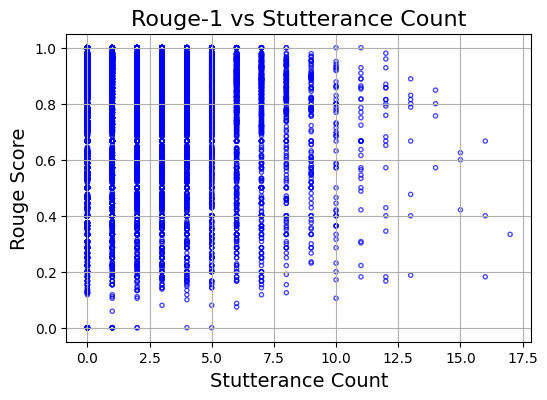

In [29]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

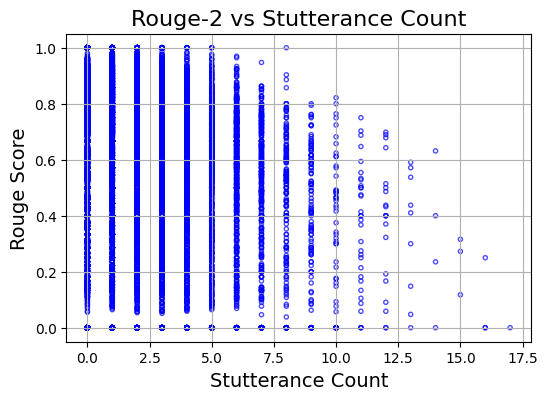

In [32]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

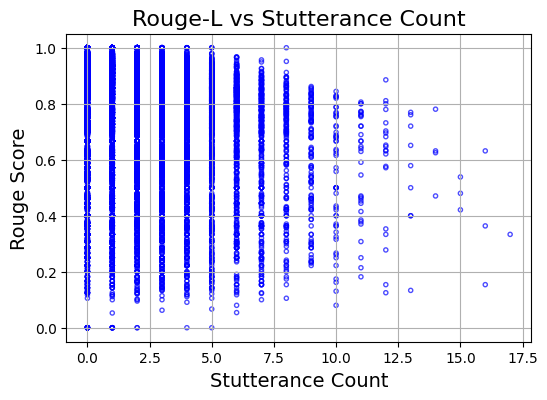

In [35]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_azure["Stutterance_Count"], 
#     net_aigenerated_data_azure["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_azure["Stutterance_Count"], 
    net_aigenerated_data_azure["rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores

In [37]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_azure.dropna()['Stutterance_Count'], net_aigenerated_data_azure.dropna()['rougel-f1'])
print(f"p-value [stuttering count & rouge-l f1] = {p}")
print(f"rho [stuttering count & rouge-l f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = -0.2170199655911308
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = -0.2653101742170816
p-value [stuttering count & rouge-l f1] = 0.0
rho [stuttering count & rouge-l f1] = -0.3261520937550862
